In [6]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import pycountry
import tqdm

from convert_json_to_parquet import get_result_paths

def get_video_df(result_path):
    result_df = pd.read_parquet(result_path, columns=['result', 'args'])
    result_df['return'] = result_df['result'].map(lambda r: r['return'])
    result_df['id'] = result_df['return'].map(lambda r: r['id'] if r and 'id' in r else None)
    video_df = result_df[result_df['id'].map(lambda i: i is not None)]
    
    return video_df

In [7]:
data_dir_path = os.path.join("..", "data")
result_paths = list(get_result_paths(data_dir_path))
result_paths = sorted(result_paths)

df = None
result_paths = result_paths[:10]
for result_path in tqdm.tqdm(result_paths):
    batch_df = get_video_df(result_path)

    if df is None:
        df = batch_df
    else:
        df = pd.concat([df, batch_df])

100%|██████████| 10/10 [01:03<00:00,  6.32s/it]


In [8]:
df['desc'] = df['return'].map(lambda r: r['desc'])
df['authorUniqueId'] = df['return'].map(lambda r: r['author']['uniqueId'] if r['author'] else None)
df['commentCount'] = df['return'].map(lambda r: int(r['stats']['commentCount']) if r['stats'] else None)
df['diggCount'] = df['return'].map(lambda r: int(r['stats']['diggCount']) if r['stats'] else None)
df['shareCount'] = df['return'].map(lambda r: int(r['stats']['shareCount']) if r['stats'] else None)
df['playCount'] = df['return'].map(lambda r: int(r['stats']['playCount']) if r['stats'] else None)
df['videoDuration'] = df['return'].map(lambda r: r['video']['duration'])
df['isImagePost'] = df['return'].map(lambda r: 'imagePost' in r)
df['numImages'] = df['return'].map(lambda r: len(r['imagePost']['images']) if 'imagePost' in r and r['imagePost'] else 0)
df['locationCreated'] = df['return'].map(lambda r: r['locationCreated'])
df[['authorUniqueId', 'desc', 'commentCount', 'diggCount', 'shareCount', 'playCount', 'videoDuration', 'isImagePost', 'numImages', 'locationCreated']].head()

,authorUniqueId,desc,commentCount,diggCount,shareCount,playCount,videoDuration,isImagePost,numImages,locationCreated
1962,izaangarciiaa__,#foryougymtok #parati #cambiofisico #1year,2.0,53.0,0.0,1447.0,0.0,True,3,ES
1979,juju._books,#pourtoi #foryou #BookTok #Clubdeslecteurs #bo...,0.0,46.0,0.0,307.0,0.0,True,3,FR
2064,agya.chota.puruna,,0.0,0.0,0.0,2.0,53.0,True,0,LT
2081,christos.a..chask,,0.0,5.0,0.0,812.0,20.0,True,0,GR
2354,tocabocavideos50,#dúo con @tocabocaLHP #toca,0.0,9.0,0.0,77.0,63.0,True,0,DO


In [27]:
print(f"Number of unique users: {len(df['authorUniqueId'].unique())}")
print(f"Average number of comments: {df['commentCount'].mean()}")
print(f"Average number of likes: {df['diggCount'].mean()}")
print(f"Average number of shares: {df['shareCount'].mean()}")
print(f"Average number of plays: {df['playCount'].mean()}")
print(f"Average video duration: {df['videoDuration'].mean()}")

Number of unique users: 12497
Average number of comments: 4.108892058963385
Average number of likes: 152.07695355840863
Average number of shares: 5.138135996195911
Average number of plays: 2250.7939451577113
Average video duration: 23.005468378506894


In [28]:
df['locationCreated'].value_counts()

locationCreated
PK    1884
US    1048
BD     930
ID     575
SA     426
      ... 
ME       1
BI       1
XK       1
CV       1
BS       1
Name: count, Length: 161, dtype: int64

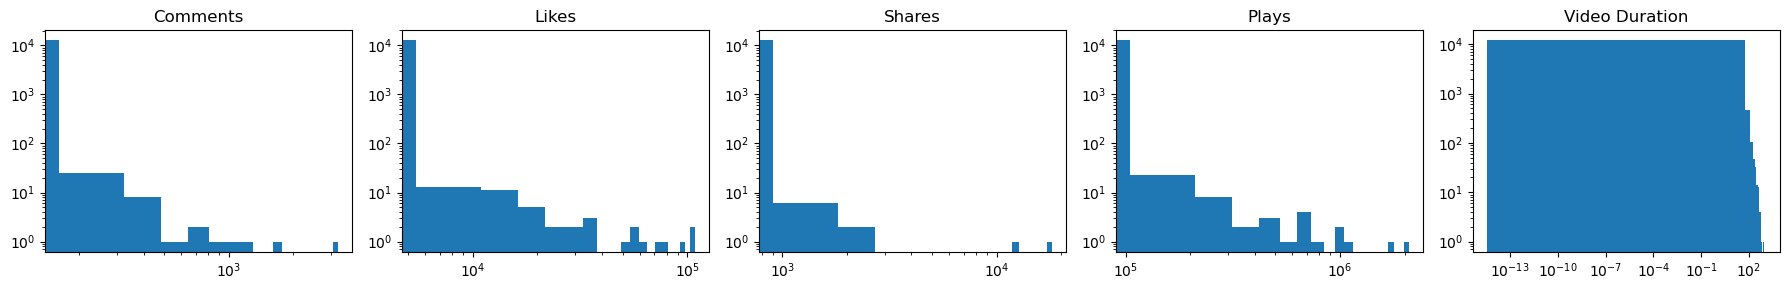

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(18, 3))
cols = ['commentCount', 'diggCount', 'shareCount', 'playCount', 'videoDuration']
titles = ['Comments', 'Likes', 'Shares', 'Plays', 'Video Duration']
for i in range(5):
    bins = 20
    # col_data = df[df[cols[i]].notna()][cols[i]]
    # hist, bins = np.histogram(col_data, bins=bins)
    # logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    axes[i].hist(df[cols[i]], bins=20)#logbins)
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_title(titles[i])

plt.tight_layout()
plt.show()

In [19]:
country_df = df[['id', 'locationCreated']].groupby('locationCreated').count().reset_index()
country_df['count'] = country_df['id']
country_df = country_df[country_df['locationCreated'].map(lambda c: c is not None)]
def get_alpha_3(alpha_2):
    try:
        return pycountry.countries.get(alpha_2=alpha_2).alpha_3
    except:
        extra_map = {
            'XK': 'UNK'
        }
        if alpha_2 in extra_map:
            return extra_map[alpha_2]
        else:
            print(f"Couldn't find {alpha_2}")
            return None
country_df['iso_alpha'] = country_df['locationCreated'].map(get_alpha_3)
fig = px.choropleth(country_df, locations="iso_alpha",
                    color="count", # lifeExp is a column of gapminder
                    # hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

Couldn't find FAKE-AD


In [ ]:
pop_df = pd.read_csv
fig = px.choropleth(country_df, locations="iso_alpha",
                    color="count", # lifeExp is a column of gapminder
                    # hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()